In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pandas as pd

from matplotlib import patches
from keras.models import model_from_json

%matplotlib inline

Using TensorFlow backend.


### 0. Implement Required Method

In [2]:
# Compute IOU(Measure TP, FP)
def ComputeIOU(gt_bbox, p):
    x1 = np.maximum(gt_bbox[0], p[:, 0])
    y1 = np.maximum(gt_bbox[1], p[:, 1])
    x2 = np.minimum(gt_bbox[2], p[:, 2])
    y2 = np.minimum(gt_bbox[3], p[:, 3])
    
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    gt_area = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    propoesed_area = (p[:, 2] - p[:, 0]) * (p[:, 3] - p[:, 1])
    union = gt_area + propoesed_area[:] - intersection[:]
    
    iou = intersection/union
    
    return iou

# Bounding Box Normalization
def NonMaximumSuppression(boxes):
    NMS_TH = 0.5
    pick = []

    # Sorted by Score(Confidence)
    idx = np.argsort(boxes[:, 4])

    while len(idx) > 0:
        last = len(idx) - 1
        i = idx[last]
        pick.append(i)
        iou = ComputeIOU(boxes[i], boxes[idx[:last]])
        idx = np.delete(idx, np.concatenate(([last], np.where(iou > NMS_TH)[0])))

    return boxes[pick]

### 1. Load Classification Trained Model

In [25]:
# 1. Network Model Load
ROOT_DIR = os.path.abspath('./')
EXP_DIR = os.path.abspath('./experiments')
JOB_DIR = os.path.join(EXP_DIR, 'vgg16-airplane')

# 1-1. Network model structure json load
json_file = open("{}/network_model.json".format(JOB_DIR), "r")
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
    
# 1-2. Trained weight load and Copy to model
model.load_weights("{}/trained_weight.h5".format(JOB_DIR))

### 2. Image Load

In [26]:
# 2. Image Load
IMG_DIR = os.path.join(ROOT_DIR, 'data/air_planes/images')

img_list = os.listdir(IMG_DIR)
img_file = random.choice(img_list)
img_path = os.path.join(IMG_DIR, img_file)
print('Image Path ::', img_path)

img = cv2.imread(img_path)

Image Path :: /home/jhjung/deeplearning_research/object_detection/RCNN/data/air_planes/images/airplane_345.jpg


### 3. Proposal Region Using Selective Search

In [27]:
# 3. Proposal Region using Selective Search
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()

print('Selective Search Result Shape ::', ssresults.shape)

Selective Search Result Shape :: (707, 4)


### 4. Pridict Object

In [29]:
# 4. Each Proposed region CNN Forward Pass
predict_regions = np.array([], dtype=np.float32).reshape(0, 5)
for i, region in enumerate(ssresults):
    x, y, w, h = region
    timg = img[y : y+h, x : x + w]
    rimg = cv2.resize(timg, (224, 224), interpolation = cv2.INTER_AREA)
    rimg = np.divide(rimg, 255.)
    inimg = np.expand_dims(rimg, axis=0)
    output = model.predict(inimg)
    if output[0][1] > 0.9:
        region = region.astype(np.float32)
        tmp = np.insert(region, 4, output[0][1])
        predict_regions = np.vstack([predict_regions, tmp])
        
# Ground Truth 좌표형태(xmin, ymin, xmax, ymax) 맞춰주기 위해서
predict_regions[:, 2] = predict_regions[:, 0] + predict_regions[:, 2]
predict_regions[:, 3] = predict_regions[:, 1] + predict_regions[:, 3]
print('Predict Regions ::', predict_regions.shape)

Predict Regions :: (2, 5)


### 5. Bounding Box Regression

In [30]:
# 5. Apply Bounding Box regression
# 5-1. BBox Regression Network Model Load
ROOT_DIR = os.path.abspath('./')
EXP_DIR = os.path.abspath('./experiments')
JOB_DIR = os.path.join(EXP_DIR, 'vgg16-airplane/reg')

# 5-1. BBox Regression Network model structure json load
json_file = open("{}/network_model.json".format(JOB_DIR), "r")
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
    
# 5-2. BBox Regression Trained weight load and Copy to model
model.load_weights("{}/trained_weight.h5".format(JOB_DIR))

for i, region in enumerate(predict_regions):
    x, y, w, h, _= region
    timg = img[int(y) : int(y+h), int(x) : int(x + w)]
    rimg = cv2.resize(timg, (224, 224), interpolation = cv2.INTER_AREA)
    rimg = np.divide(rimg, 255.)
    inimg = np.expand_dims(rimg, axis=0)
    reg_output = model.predict(inimg)

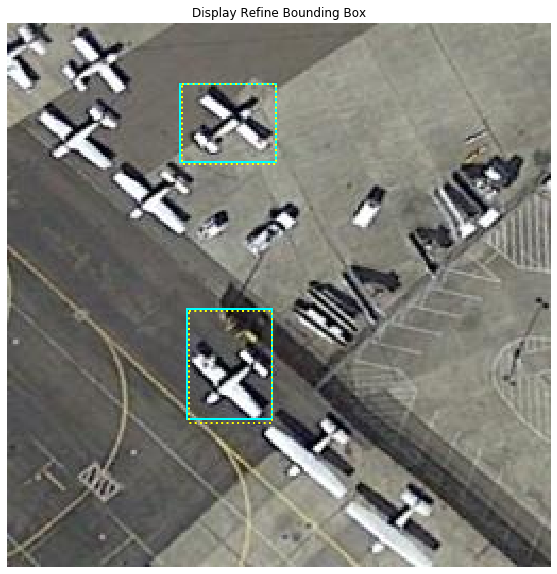

In [31]:
# Refine BBox Display
refine_regions = predict_regions.copy()
if refine_regions.shape[0] > 0:
    refine_regions[:, 0] = np.trunc((refine_regions[:, 2] * reg_output[:, 0]) + refine_regions[:, 0])
    refine_regions[:, 1] = np.trunc((refine_regions[:, 3] * reg_output[:, 1]) + refine_regions[:, 1])
    refine_regions[:, 2] = np.trunc(refine_regions[:, 2] * np.exp(reg_output[:, 2]))
    refine_regions[:, 3] = np.trunc(refine_regions[:, 3] * np.exp(reg_output[:, 3]))

    fig, ax = plt.subplots(1, figsize=(10, 10))

    for bbox in predict_regions:
        x1, y1, x2, y2, _ = bbox
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, alpha=1.0, linestyle="solid", edgecolor='cyan', facecolor='none')
        ax.add_patch(p)


    for bbox in refine_regions:
        x1, y1, x2, y2, _ = bbox
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, alpha=1.0, linestyle=":", edgecolor='yellow', facecolor='none')
        ax.add_patch(p)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    ax.set_title('Display Refine Bounding Box')

### 6. Apply Non Naximum Suppression

In [32]:
# 6. Apply Non Naximum Suppression
nms_regions = NonMaximumSuppression(refine_regions)
print('Before regions ::', refine_regions.shape)
print('NMS regions ::', nms_regions.shape)

Before regions :: (2, 5)
NMS regions :: (2, 5)


### 7. Evaluation

In [33]:
# 7. Evaluation
EVAL_TH = 0.5

# 7-1. Read GT Data
ANN_DIR = os.path.join(ROOT_DIR, 'data/air_planes/annotations')
ann_list = os.listdir(ANN_DIR)
ann_file = '{}.csv'.format(img_file.split('.')[0])
ann_path = os.path.join(ANN_DIR, ann_file)
print('annotation path ::', ann_path)

ann = pd.read_csv(ann_path)
gt_bboxes = np.array([], dtype=np.int32).reshape(0, 4)
for row in ann.iterrows():
    line = row[1][0].split(" ")
    x1 = int(line[0])
    y1 = int(line[1])
    x2 = int(line[2])
    y2 = int(line[3])
    gt_bboxes = np.vstack([gt_bboxes, [x1, y1, x2, y2]])

# 7-2. Compute IOU Between GT and Predict Regions
eval_result = np.array([], dtype=np.int32).reshape(0, 6)
p = nms_regions.copy()

for gt_bbox in gt_bboxes:
    iou = ComputeIOU(gt_bbox, p)
    measure = np.where(iou > EVAL_TH)[0]
    
    if len(measure) == 0:
        continue
    
    # GT 당 1개의 Predict BBox가 있다면 TP,
    # 여러개의 Predict BBox가 있다면 1개만 TP 나머지는 FP
    if len(measure) == 1:
        tmp_tp = np.insert(p[measure], 5, 1, axis=1)
        eval_result = np.vstack([eval_result, tmp_tp])
    else:
        tp_idx = np.argmax(p[measure][:,-1])
        tmp_tp = np.insert(p[tp_idx], 5, 1)

        eval_result = np.vstack([eval_result, tmp_tp])
        fp_idx = np.delete(measure, tp_idx)
        if len(fp_idx) > 0:
            tmp_fp = np.insert(p[fp_idx], 5, 0, axis=1)
            eval_result = np.vstack([eval_result, tmp_fp])
    
    p = np.delete(p, measure, axis=0)

# TP Measure 후 남은 Bounding Box는 모두 FP
if len(p) > 0:
    p = np.insert(p, 5, 0, axis=1)
    eval_result = np.vstack([eval_result, p])


annotation path :: /home/jhjung/deeplearning_research/object_detection/RCNN/data/air_planes/annotations/airplane_345.csv


### 8. Visualize

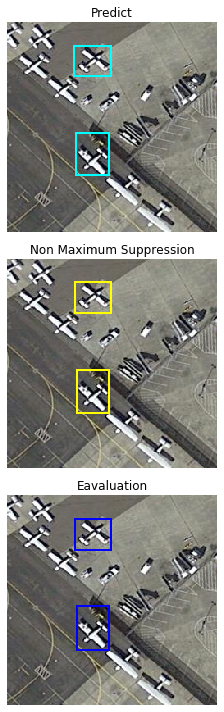

In [34]:
# Bounding BBox Display
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

for bbox in predict_regions:
    x1, y1, x2, y2, _ = bbox
    p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, alpha=1.0, linestyle="solid", edgecolor='cyan', facecolor='none')
    ax[0].add_patch(p)
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[0].axis('off')
    ax[0].set_title('Predict')
    
for bbox in nms_regions:
    x1, y1, x2, y2, _ = bbox
    p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, alpha=1.0, linestyle="solid", edgecolor='yellow', facecolor='none')
    ax[1].add_patch(p)
    ax[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[1].axis('off')
    ax[1].set_title('Non Maximum Suppression')

for bbox in eval_result:
    x1, y1, x2, y2, _, measure = bbox
    color = 'blue' if measure == 1 else 'red'
    p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, alpha=1.0, linestyle="solid", edgecolor=color, facecolor='none')
    ax[2].add_patch(p)
    ax[2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[2].axis('off')
    ax[2].set_title('Eavaluation')
    
plt.tight_layout()